# GEOSF636 Term Presentation / Josh Monroe

## 1. Introduction
For my project, I am compiling water quality data from the Chena River in an attempt to cross reference in-situ measurements (specifically turbidity) against remotely sensed images of the river. Theoretically, with many referenced points of turbidity and image pixel values, a model could be used to predict turbidity at a given location of a water body using only remotely sensed imagery. 

## 2. Sonde Locations

Water quality data from six HydroLab DS5 sondes will be used in my project. Four of which are analyzed though this presentation. Data from the other two sondes are still being retrieved. Several different logger locations are given in the file `Chena_Logger_Locations.csv`. In order to choose only the sondes associated with my project, I performed the following command:

In [ ]:
!awk -F, 'BEGIN { OFS = "," } ; index($4, "DS5") {print $3, $2, $1}' Chena_Logger_Locations.csv > Edited_Locations.csv

### 2.1 GMT Sonde Locations Code

Next, I will display the Sonde Locations using GMT.

In [ ]:
gmt begin SondeLocations png
    gmt grdimage @earth_relief_01s -R-148/-146/64/65 -JM5i -Ctopo -I
    gmt grdcontour @earth_relief_01s -R-148/-146/64/65 -JM5i -C250 -A500
    gmt coast -R-148/-146/64/65 -JM5i \
        -W0.25,black -Ia/1p,darkblue \
        -Sblue -Df -Wthin -BWSne -Baf -Lg-146.2/64.1+c-146.2/64.1+w10+f+l
    gmt plot Fairbanks.xy -Sc0.3 -Gblack -l"Fairbanks"
gmt end

### 2.2 GMT Sonde Locations Result
Using the code above, the following figure is produced. Note that `gmt coast` does not produce line vectors for streams of lower order than the Tanana River. Therefore, it seems as if the Sensor Locations are on land but this is not the case; just that the global hydrography dataset contained within `gmt coast` does not have the resolution to plot the Chena River.

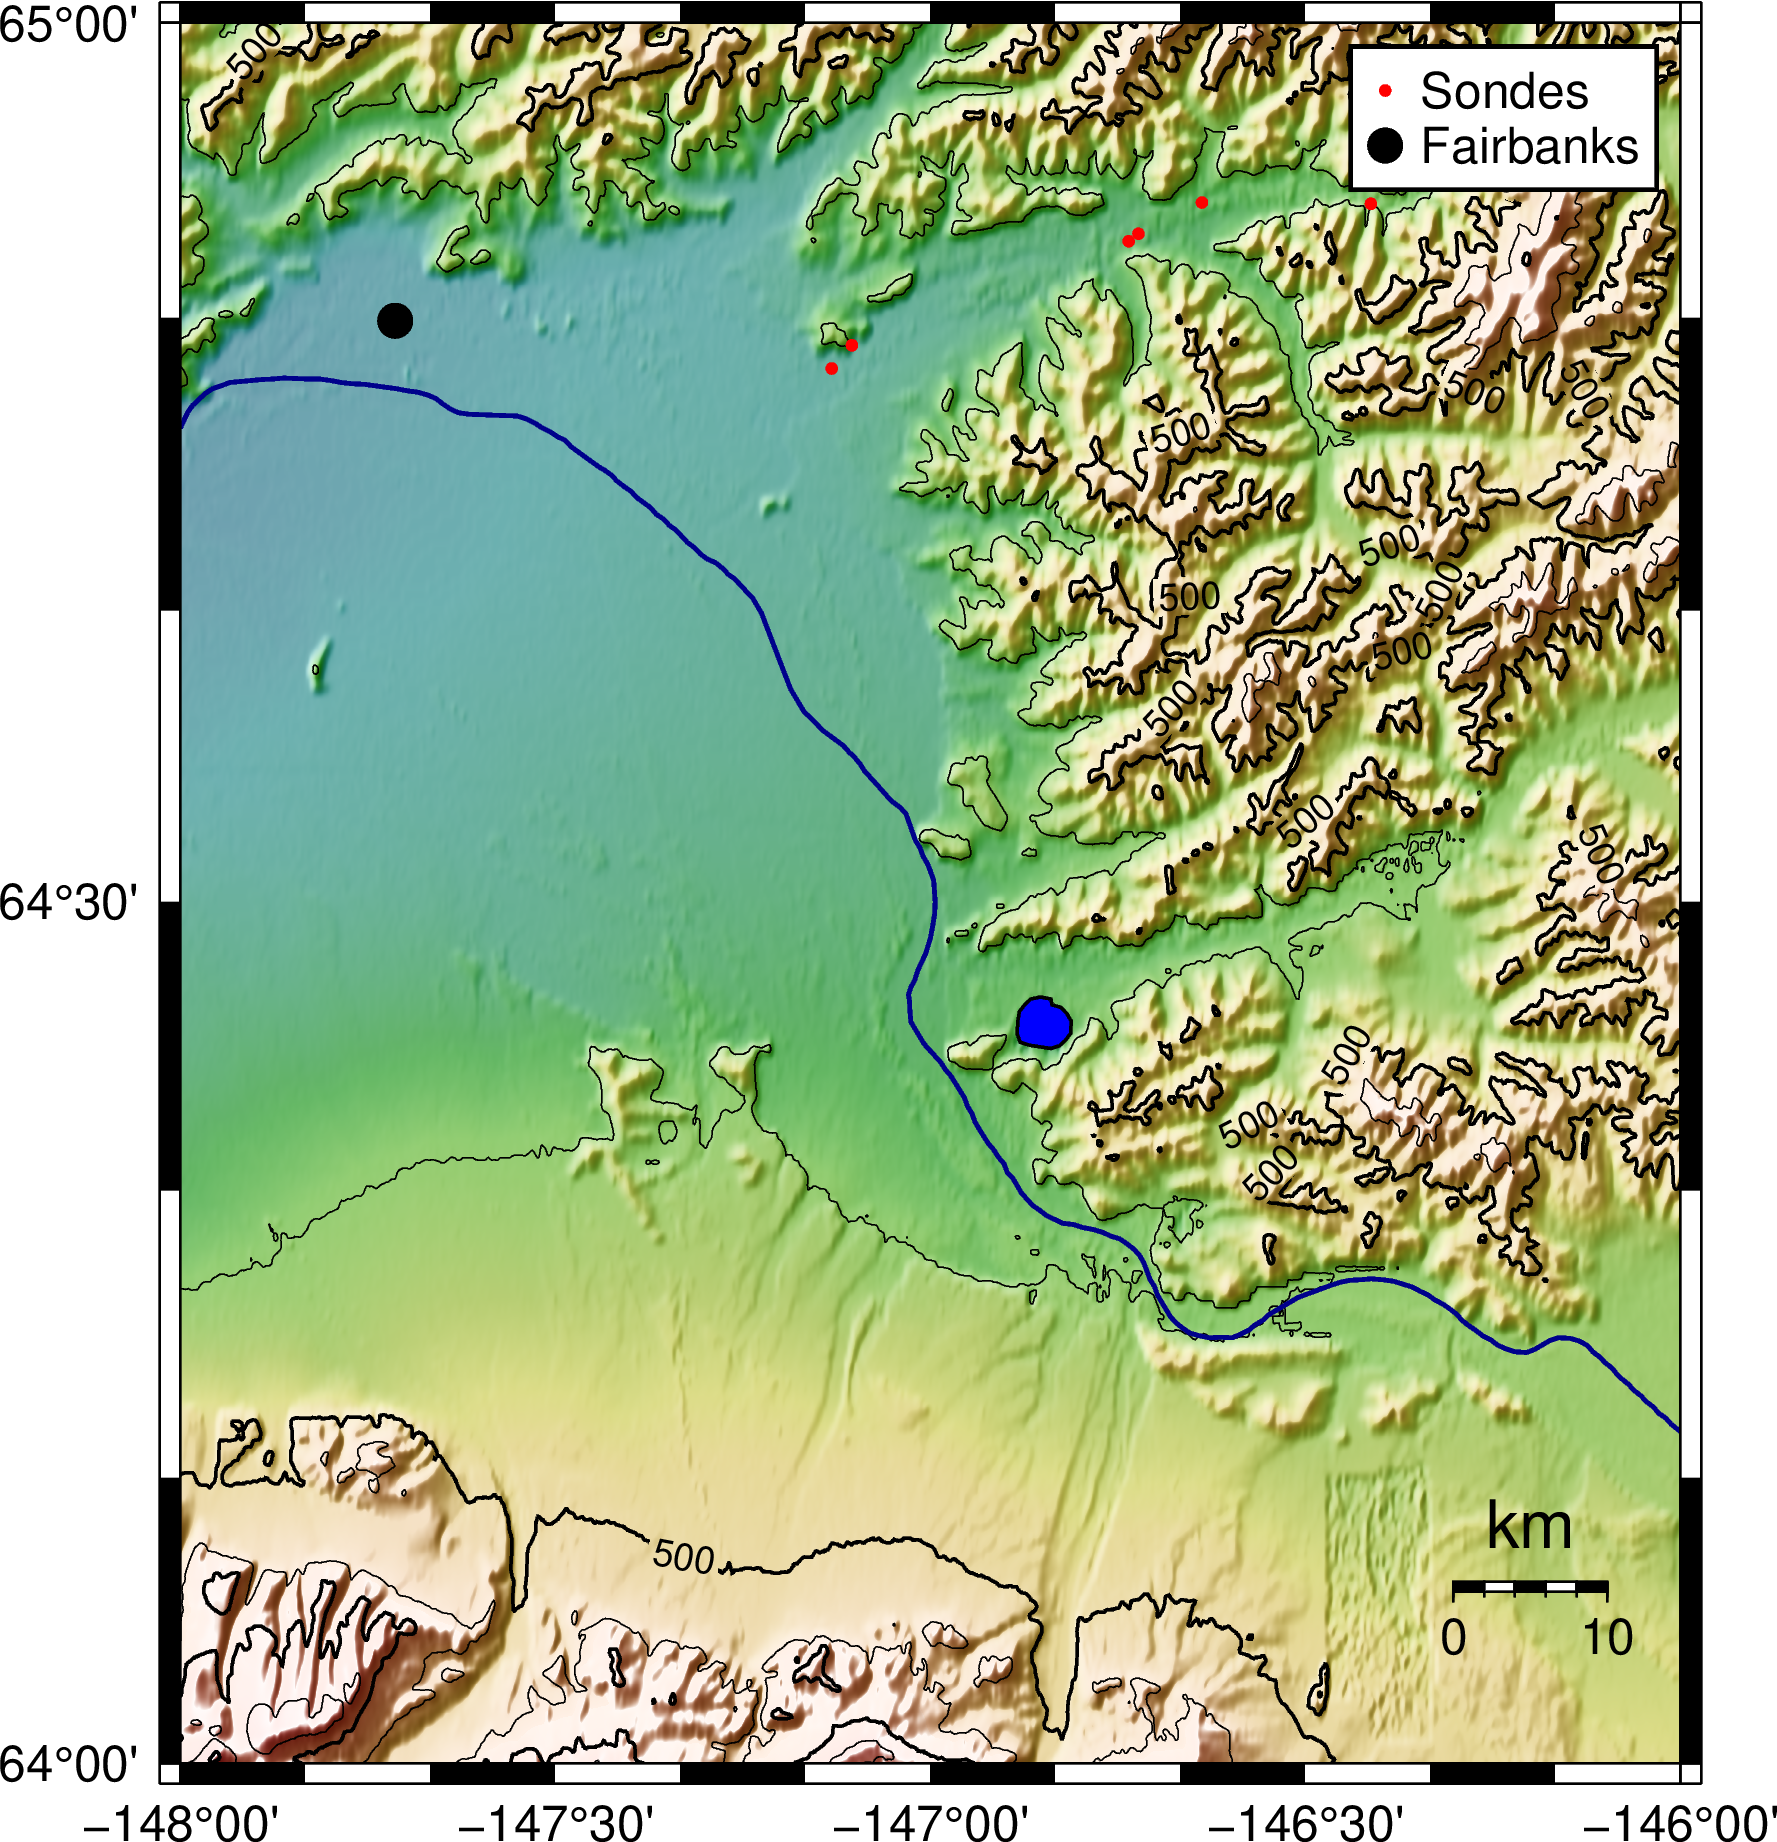

## 3. Data
I have Sonde Station Data from a previous study conducted by Benson, et. al. 2009.I will also be using Sonde Station Data from select sites of the Chena River from a more recent study conducted by Schoen, et. al (pending). The Benson data encompasses 4 Sonde Locations along the Chena River across two years (2008 & 2009). It is currently formatted as shown by this figure (obtained with `!head -n 20 DS1_2008.csv`). The files are named according to the station number and year of collection.

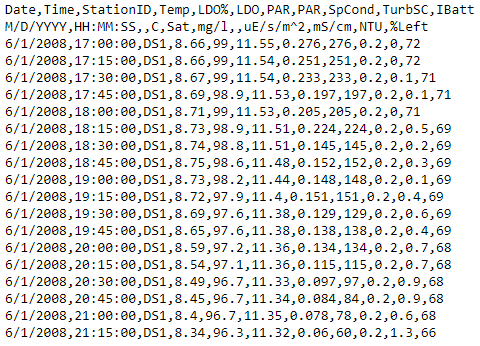

### 3.1 Re-format Data Code

In order to work with all data from all files, I use `awk` and `sed` to re-format the files into one "Benson_Master.csv" file while also renaming the columns to include units in parentheses.

In [3]:
#Create Master CSV and re-format header

!awk -F, 'FNR==1 {print $0}' DS1_2008.csv > Benson_Master.csv
!awk -F, 'FNR>2 {print $0}' DS*.csv >> Benson_Master.csv
!sed -i 's/Date/Date(M/D/YYYY)/g ; s/Time/Time(HH:MM:SS)/g ; \
    s/Temp/Temp(C)/g ; s/LDO/LDO(%Sat)/g ; s/LDO/LDO(mg\/L)/g ; s/PAR/PAR(uE\/s\/m^2)/g ; \
    s/SpCond/SpCond(mS\/cm)/g ; s/TurbSC/TurbSC(NTU) ; s/IBatt/Ibatt(%Left)/g' Benson_Master.csv
!wc -l Benson_Master.csv
!head -n 10 Benson_Master.csv

73659 Benson_Master.csv
Date(M/D/YYYY),Time(HH:MM:SS),StationID,Temp(C),LDO(%Sat),LDO(mg/l),PAR(mE/s/m2),PAR(uE/s/m^2),SpCond(mS/cm),TurbSC(NTU),Ibatt(%Left)
6/1/2008,17:00:00,DS1,8.66,99,11.55,0.276,276,0.2,0,72
6/1/2008,17:15:00,DS1,8.66,99,11.54,0.251,251,0.2,0,72
6/1/2008,17:30:00,DS1,8.67,99,11.54,0.233,233,0.2,0.1,71
6/1/2008,17:45:00,DS1,8.69,98.9,11.53,0.197,197,0.2,0.1,71
6/1/2008,18:00:00,DS1,8.71,99,11.53,0.205,205,0.2,0,71
6/1/2008,18:15:00,DS1,8.73,98.9,11.51,0.224,224,0.2,0.5,69
6/1/2008,18:30:00,DS1,8.74,98.8,11.51,0.145,145,0.2,0.2,69
6/1/2008,18:45:00,DS1,8.75,98.6,11.48,0.152,152,0.2,0.3,69
6/1/2008,19:00:00,DS1,8.73,98.2,11.44,0.148,148,0.2,0.1,69


### 3.2 Re-format Data Result

The resulting file has 73659 rows of data encompassing four sonde locations across two years of sampling. 

## 4. Visualize Data

Next, in order to visualize the turbidity data from the four sonde locations, I'll graph the data over time. Pandas is used to create a dataframe from the data which is then split up into several smaller dataframes in the graphing process. Matplotlib subplots is utilized for side by side comparison. 

In order to account for errors or inacurracies in the data, the following parameters are used to filter out records which likely contain erroneous data:
* Turbidity (NTU) <= 2000
* Temperature (C) <= 20

These thresholds are employed because outliers in the data can have a dramatic effect on graph illustration and analysis. Turbidity above 2000 likely means an inaccurate sensor calibration or clogged sensor probe. Temperature above 20 degrees C likely means the probe is out of water and not measuring meaningful in-situ water quality data.

Following this illustration, I'll look at total data availability for each 15 minute interval during the sampling period to locate the periods where this data does not have a turbidity measurement. This will allow me to focus on periods of turbidity data availability when searching for satellite imagery to cross reference. 

### 4.1 Visualize Data Code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Benson_Master.csv', sep=',', header=0)

#Insert Datetime column using existing Date and Time columns
df.insert(loc=2, column='Datetime', value=pd.to_datetime(df['Date(M/D/YYYY)'] + ' ' + df['Time(HH:MM:SS)']))

#Create several dataframes for each station for a given year
df2008DS1 = df[(df['Datetime'] <= '2008-09-29') & (df['TurbSC(NTU)'] <= 2000) & (df['StationID'] == 'DS1') & (df['Temp(C)'] <= 20)]
df2008DS2 = df[(df['Datetime'] <= '2008-09-29') & (df['TurbSC(NTU)'] <= 2000) & (df['StationID'] == 'DS2') & (df['Temp(C)'] <= 20)]
df2008DS3 = df[(df['Datetime'] <= '2008-09-29') & (df['TurbSC(NTU)'] <= 2000) & (df['StationID'] == 'DS3') & (df['Temp(C)'] <= 20)]
df2008DS4 = df[(df['Datetime'] <= '2008-09-29') & (df['TurbSC(NTU)'] <= 2000) & (df['StationID'] == 'DS4') & (df['Temp(C)'] <= 20)]
df2009DS1 = df[(df['Datetime'] >= '2008-09-29') & (df['TurbSC(NTU)'] <= 2000) & (df['StationID'] == 'DS1') & (df['Temp(C)'] <= 20)]
df2009DS2 = df[(df['Datetime'] >= '2008-09-29') & (df['TurbSC(NTU)'] <= 2000) & (df['StationID'] == 'DS2') & (df['Temp(C)'] <= 20)]
df2009DS3 = df[(df['Datetime'] >= '2008-09-29') & (df['TurbSC(NTU)'] <= 2000) & (df['StationID'] == 'DS3') & (df['Temp(C)'] <= 20)]
df2009DS4 = df[(df['Datetime'] >= '2008-09-29') & (df['TurbSC(NTU)'] <= 2000) & (df['StationID'] == 'DS4') & (df['Temp(C)'] <= 20)]

#Create subplot for all available data
fig, axs = plt.subplots(4,2, sharex=False, sharey=True)
fig.suptitle('Benson 2008-2009')
axs[0,0].plot(df2008DS1['Datetime'], df2008DS1['TurbSC(NTU)'], color='red', linewidth=1.0, linestyle='solid')
axs[1,0].plot(df2008DS2['Datetime'], df2008DS2['TurbSC(NTU)'], color='green', linewidth=1.0, linestyle='solid')
axs[2,0].plot(df2008DS3['Datetime'], df2008DS3['TurbSC(NTU)'], color='blue', linewidth=1.0, linestyle='solid')
axs[3,0].plot(df2008DS4['Datetime'], df2008DS4['TurbSC(NTU)'], color='black', linewidth=1.0, linestyle='solid')
axs[0,1].plot(df2009DS1['Datetime'], df2009DS1['TurbSC(NTU)'], color='red', linewidth=1.0, linestyle='solid', label='DS1')
axs[1,1].plot(df2009DS2['Datetime'], df2009DS2['TurbSC(NTU)'], color='green', linewidth=1.0, linestyle='solid', label='DS2')
axs[2,1].plot(df2009DS3['Datetime'], df2009DS3['TurbSC(NTU)'], color='blue', linewidth=1.0, linestyle='solid', label='DS3')
axs[3,1].plot(df2009DS4['Datetime'], df2009DS4['TurbSC(NTU)'], color='black', linewidth=1.0, linestyle='solid', label='DS4')

#Set labels and ticks for outer axes
for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Turb NTU')
    ax.label_outer()
    ax.tick_params('x',labelrotation=90)

#Include a legend, located outside the figure
fig.legend(loc = 'upper right', bbox_to_anchor=(1.1,0.9), title='Legend')

#Save to file
plt.savefig('BensonTurbidity.png', bbox_inches='tight')
plt.close(fig)

In [16]:
#Plot a histogram of Datetime using the number of unique values in Datetime as bins
plt.hist(df['Datetime'], bins=df.Datetime.nunique())

#rotate x labels, give title, save to file 
plt.tick_params('x',labelrotation=90)
plt.title('Benson Turbidity Data Availability 2008-2009')
plt.savefig('BensonAvailability.png', bbox_inches='tight')
plt.close()

### 4.2 Visualize Data Results

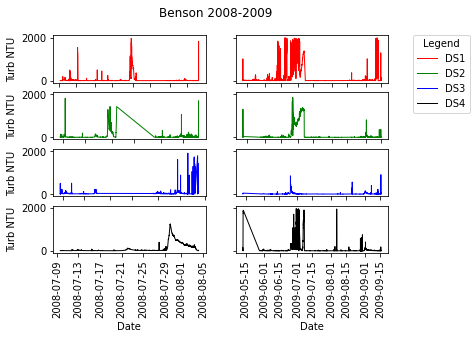
After plotting the data, it is evident that there are few trends between the two years. There are a few notable trends within years between stations though. For example, all stations had spikes in turbidity around 2009-07-01 but to varying degrees and duration. In-situ measurements may be highly dependent on the microsite in which the sensor is positioned.

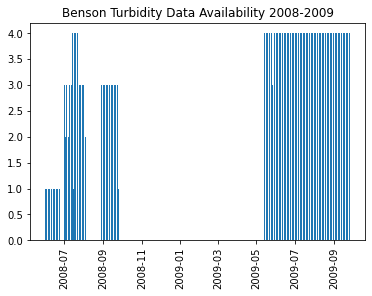
Checking data availability shows where the gaps in in-situ measurements are. For a given 15-minute interval, this figure shows how many of the Sonde locations have a turbidity reading for that time. Since the aim is to obtain a relationship between in-situ data and satellite images, I can narrow my search to only those times where where in-situ data is available. 

## 5. Conclusion
Data availability differed greatly between 2008 and 2009 as evident by the y-axis of the figure "Benson Turbidity Data Availability 2008-2009". There was much more consistent data collection over the 2009 sampling period. The 2008 sampling period had less coverage and had fewer insances of multiple measurements across the sonde locations. In addition, gaps in data collection are evident (specifically DS2 in 2008). These data collection gaps during the sampling period can be attributed to environmental or infrastructure issues. Gaps such as these may impact the quantity of measurements to be cross referenced against remotely sensed imagery for development of a prediction model.

Despite the inclusion of a turbidity data cap, there are several records which include measurements close to the cap that cause the charts to be showcases of outliers as opposed to seasonal trends. 

## 6. Next Steps

A similar analysis and visualization of data from 2019-2020 Sonde data is needed to determine data feasability and availability.

Remotely sensed imagery will be downloaded from Planet Explorer and USGS Landsat repositories. Imagery at each of the Sonde Locations will be analyzed for Normalized Difference Water Index (NDWI) Value and checked against in-situ data for development of the prediction model.